In [8]:
import os
from pathlib import Path

def pick_writable_base():
   
    candidates = [Path.cwd(), Path("/notebooks"), Path.home(), Path("/tmp")]
    for base in candidates:
        try:
            base.mkdir(parents=True, exist_ok=True)
            test_file = base / ".write_test"
            test_file.write_text("ok", encoding="utf-8")
            test_file.unlink()
            return base
        except Exception:
            continue
    raise RuntimeError("Could not find a writable directory. Try using /tmp or /notebooks explicitly.")

BASE_DIR = pick_writable_base()
PROJECT_DIR = BASE_DIR / "stock_project"

# Create folders we will use
RAW_DIR = PROJECT_DIR / "data" / "raw"
PROC_DIR = PROJECT_DIR / "data" / "processed"
FIG_DIR = PROJECT_DIR / "reports" / "figures"
TAB_DIR = PROJECT_DIR / "reports" / "tables"

for d in [RAW_DIR, PROC_DIR, FIG_DIR, TAB_DIR]:
    d.mkdir(parents=True, exist_ok=True)

os.chdir(PROJECT_DIR)

print("BASE_DIR:", BASE_DIR)
print("PROJECT_DIR:", PROJECT_DIR)
print("Working directory is now:", Path.cwd())
print("Folders created:")
print(" -", RAW_DIR)
print(" -", PROC_DIR)
print(" -", FIG_DIR)
print(" -", TAB_DIR)

BASE_DIR: /notebooks
PROJECT_DIR: /notebooks/stock_project
Working directory is now: /notebooks/stock_project
Folders created:
 - /notebooks/stock_project/data/raw
 - /notebooks/stock_project/data/processed
 - /notebooks/stock_project/reports/figures
 - /notebooks/stock_project/reports/tables


# Install required libraries

We install the minimum packages needed for:
- downloading stock data (yfinance)
- downloading macroeconomic data from FRED (pandas-datareader)
- data handling (pandas, numpy)
- saving datasets (pyarrow for parquet)
- plotting (matplotlib)
- GARCH models (arch)

In [9]:
%pip -q install yfinance pandas-datareader pyarrow arch pandas numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


# Imports and experiment settings

We define:
- the list of tech stocks (our asset universe)
- a market proxy (SPY)
- a volatility proxy (^VIX)
- the date range

We also define train/validation/test split dates based on *target dates* (the day we are predicting).
This avoids a subtle form of time-series leakage.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
from pandas_datareader.data import DataReader

from pathlib import Path

# Reconstruct paths (safe after kernel restart)
PROJECT_DIR = Path.cwd()
RAW_DIR = PROJECT_DIR / "data" / "raw"
PROC_DIR = PROJECT_DIR / "data" / "processed"
FIG_DIR = PROJECT_DIR / "reports" / "figures"
TAB_DIR = PROJECT_DIR / "reports" / "tables"

# Experiment parameters (edit if you want)
START_DATE = "2010-01-01"
END_DATE   = "2025-12-31"

TICKERS = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "NVDA", "TSLA", "ORCL"]
MARKET_TICKER = "SPY"
VIX_TICKER = "^VIX"

# Time splits (based on the date we are forecasting, i.e., target_date)
TRAIN_END = "2019-12-31"
VAL_END   = "2022-12-31"
TEST_END  = "2025-12-31"

print("Tickers:", TICKERS)
print("Market:", MARKET_TICKER, "VIX:", VIX_TICKER)
print("Date range:", START_DATE, "to", END_DATE)
print("Splits:", TRAIN_END, VAL_END, TEST_END)

Tickers: ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'NVDA', 'TSLA', 'ORCL']
Market: SPY VIX: ^VIX
Date range: 2010-01-01 to 2025-12-31
Splits: 2019-12-31 2022-12-31 2025-12-31


In [11]:
import os
from pathlib import Path

# Find where your 'stock_project' folder is
candidates = [
    Path("/notebooks/stock_project"),
    Path("/notebook/stock_project"),
    Path.cwd() / "stock_project",
    Path.home() / "stock_project",
    Path("/tmp/stock_project")
]

PROJECT_DIR = None
for p in candidates:
    if p.exists() and p.is_dir():
        PROJECT_DIR = p
        break

# If it truly doesn't exist yet, create it in a safe place
if PROJECT_DIR is None:
    base = Path("/notebooks") if Path("/notebooks").exists() else Path.cwd()
    PROJECT_DIR = base / "stock_project"
    PROJECT_DIR.mkdir(parents=True, exist_ok=True)

# Move into project directory
os.chdir(PROJECT_DIR)

# Define folder structure
RAW_DIR = Path("data/raw")
PROC_DIR = Path("data/processed")
FIG_DIR = Path("reports/figures")
TAB_DIR = Path("reports/tables")

# Ensure folders exist
for d in [RAW_DIR, PROC_DIR, FIG_DIR, TAB_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("Working directory:", Path.cwd())
print("RAW_DIR:", RAW_DIR.resolve())
print("PROC_DIR:", PROC_DIR.resolve())
print("FIG_DIR:", FIG_DIR.resolve())
print("TAB_DIR:", TAB_DIR.resolve())

Working directory: /notebooks/stock_project
RAW_DIR: /notebooks/stock_project/data/raw
PROC_DIR: /notebooks/stock_project/data/processed
FIG_DIR: /notebooks/stock_project/reports/figures
TAB_DIR: /notebooks/stock_project/reports/tables


# Download raw data

We download:

1) Adjusted close prices (so stock splits/dividends are handled consistently) for:
- the tech tickers
- SPY (market proxy)
- VIX (^VIX)

2) Macroeconomic series from FRED:
- DFF: Effective Federal Funds Rate
- DGS10: 10-Year Treasury Constant Maturity Rate
- SP500: S&P 500 index level (from FRED)

Why save raw data?
- Reproducibility: you can rerun later without silently changing the dataset.
- Debugging: if something looks wrong downstream, you can inspect raw inputs.

In [12]:
def download_adj_close(tickers, start, end):
    """
    Downloads adjusted close prices from yfinance.
    Returns a DataFrame: index=Date, columns=tickers, values=Adj Close
    """
    df = yf.download(
        tickers=tickers,
        start=start,
        end=end,
        auto_adjust=True,   # key: uses adjusted prices
        progress=False,
        group_by="ticker"
    )

    # MultiIndex columns when multiple tickers
    if isinstance(df.columns, pd.MultiIndex):
        close = df.xs("Close", axis=1, level=1)
    else:
        # Single ticker case
        close = df[["Close"]]
        close.columns = tickers

    close.index.name = "Date"
    return close.sort_index()

def download_fred(series_codes, start, end):
    """
    Downloads FRED data using pandas-datareader.
    Returns a DataFrame indexed by Date.
    """
    return DataReader(series_codes, "fred", start, end).sort_index()

# 1) Prices
all_price_tickers = sorted(set(TICKERS + [MARKET_TICKER, VIX_TICKER]))
prices = download_adj_close(all_price_tickers, START_DATE, END_DATE)
prices.to_csv(RAW_DIR / "prices_adj_close.csv")

print("Saved:", RAW_DIR / "prices_adj_close.csv")
print("Prices shape:", prices.shape)
display(prices.tail())

# 2) FRED macro (safe try/except in case FRED is blocked)
fred_codes = ["DFF", "DGS10", "SP500"]
try:
    fred = download_fred(fred_codes, START_DATE, END_DATE)
    fred.to_csv(RAW_DIR / "fred_macro.csv")
    print("Saved:", RAW_DIR / "fred_macro.csv")
    print("FRED shape:", fred.shape)
    display(fred.tail())
except Exception as e:
    fred = None
    print("FRED download failed. We will continue without FRED for now.")
    print("Error:", repr(e))

Saved: data/raw/prices_adj_close.csv
Prices shape: (4023, 10)


Ticker,GOOGL,^VIX,TSLA,META,NVDA,ORCL,MSFT,AAPL,SPY,AMZN
Date,,,,,,,,,,
2025-12-23,314.350006,14.00,485.559998,664.940002,189.210007,194.824997,485.741333,272.105377,687.960022,232.139999
2025-12-24,314.089996,13.47,485.399994,667.549988,188.610001,196.969330,486.908630,273.554016,690.380005,232.380005
2025-12-26,313.510010,13.60,475.190002,663.289978,190.529999,197.468018,486.599365,273.144409,690.309998,232.520004
2025-12-29,313.559998,14.20,459.640015,658.690002,188.220001,194.864899,485.990753,273.504089,687.849976,232.070007
2025-12-30,313.850006,14.33,454.429993,665.950012,187.539993,196.690079,486.369904,272.824707,687.010010,232.529999


Saved: data/raw/fred_macro.csv
FRED shape: (5844, 3)


,DFF,DGS10,SP500
DATE,,,
2025-12-27,3.64,NaN,NaN
2025-12-28,3.64,NaN,NaN
2025-12-29,3.64,4.12,6905.74
2025-12-30,3.64,4.14,6896.24
2025-12-31,3.64,4.18,6845.50


## Feature dictionary (what each column means)

Each row in `panel` corresponds to one `(Date, Ticker)` pair. The task is:

> Use information available up to the end of **Date = \(t\)** to predict **target_ret**, the return on **target_date = \(t+1\)**.

---

### Identifiers

- **Date**: feature date \(t\). All predictors in this row are known by the end of day \(t\).
- **Ticker**: stock symbol (AAPL, MSFT, etc.), used to group observations by asset.
- **split**: dataset split label based on **target_date**:
  - `train`: target_date ≤ 2019-12-31  
  - `val`: 2020-01-01 to 2022-12-31  
  - `test`: 2023-01-01 to 2025-12-31  

---

### Returns (target and current return)

- **ret**: stock log return on Date \(t\):

$$
\text{ret}_t = \log(P_t) - \log(P_{t-1})
$$

where \(P_t\) is the adjusted closing price.

- **target_ret**: next-day log return (the prediction target):

$$
\text{target\_ret}_t = \log(P_{t+1}) - \log(P_t)
$$

- **target_date**: the date \(t+1\) corresponding to `target_ret`.

---

### Stock history features (momentum / mean reversion / volatility)

- **ret_lag1, ret_lag2, ret_lag3, ret_lag5, ret_lag10**  
  Past stock returns (lagged):

$$
\text{ret\_lag}_k(t) = \text{ret}_{t-k}
$$

These capture short-term momentum and mean-reversion effects.

- **ret_vol5, ret_vol10, ret_vol20**  
  Rolling realized volatility (rolling standard deviation of returns):

$$
\text{ret\_vol}_w(t)
=
\operatorname{StdDev}
\left(
\text{ret}_{t-w+1}, \ldots, \text{ret}_t
\right)
$$

These capture volatility clustering (calm vs. turbulent periods).

---

### Market and macro features (all lagged by one day)

All macro predictors are shifted by one trading day to prevent look-ahead bias.  
Therefore, they end in `_lag1`.

- **mkt_ret_lag1**: market (SPY) log return on day \(t-1\)
- **vix_level_lag1**: VIX closing level on day \(t-1\)
- **vix_ret_lag1**: VIX log return on day \(t-1\)

FRED-based series (forward-filled to trading days, then lagged):

- **DFF_lag1**: effective Fed Funds rate at \(t-1\)
- **DGS10_lag1**: 10-year Treasury yield at \(t-1\)
- **SP500_lag1**: S&P 500 index level at \(t-1\)

Stationary transforms (computed from macro series, then lagged):

- **sp500_ret_lag1**:

$$
\log(SP500_{t-1}) - \log(SP500_{t-2})
$$

- **DFF_diff_lag1**:

$$
DFF_{t-1} - DFF_{t-2}
$$

- **DGS10_diff_lag1**:

$$
DGS10_{t-1} - DGS10_{t-2}
$$

# Build a panel dataset with features and targets

We now build a "panel" dataset where each row is:
(Date, Ticker) + Features + Target

Key definitions:
- Return (log return): r_t = log(P_t) - log(P_{t-1})
- Target: target_ret = r_{t+1} (next-day return)

Why next-day target?
- It defines a clean forecasting task: use information up to day t to predict day t+1.

Leakage prevention:
- Macro features are lagged by 1 day before being used.
- Splits are assigned by target_date (the date being predicted), not feature date.

Outputs saved:
- data/processed/panel.parquet
- data/processed/audit_summary.csv

In [13]:
import numpy as np
import pandas as pd

# ---------- Robust FRED loader ----------
def load_fred_csv(path):
    df0 = pd.read_csv(path)
    # Try common date column names
    for c in ["Date", "DATE", "date"]:
        if c in df0.columns:
            date_col = c
            break
    else:
        # Fallback: first column is date
        date_col = df0.columns[0]

    df = pd.read_csv(path, parse_dates=[date_col])
    df = df.set_index(date_col).sort_index()
    df.index.name = "Date"
    return df

# ---------- Load raw data ----------
prices = pd.read_csv(RAW_DIR / "prices_adj_close.csv", parse_dates=["Date"], index_col="Date").sort_index()

fred_path = RAW_DIR / "fred_macro.csv"
fred = load_fred_csv(fred_path) if fred_path.exists() else None

print("Prices shape:", prices.shape)
print("FRED loaded:", fred is not None)
if fred is not None:
    print("FRED shape:", fred.shape)
    display(fred.tail())

# ---------- Helpers ----------
def log_returns(price_df: pd.DataFrame) -> pd.DataFrame:
    return np.log(price_df).diff()

# ---------- Returns ----------
rets = log_returns(prices)

# ---------- Panel base (Date × Ticker) ----------
panel = (
    rets[TICKERS]
    .stack()
    .rename("ret")
    .reset_index()
    .rename(columns={"level_1": "Ticker"})
)

# ---------- Macro features aligned to trading days ----------
macro = pd.DataFrame(index=rets.index)
macro["mkt_ret"] = rets[MARKET_TICKER]
macro["vix_level"] = prices[VIX_TICKER]
macro["vix_ret"] = log_returns(prices[[VIX_TICKER]]).iloc[:, 0]

if fred is not None:
    macro = macro.join(fred, how="left")

# Align macro to trading days and forward-fill missing values
macro = macro.reindex(rets.index).ffill()

if "SP500" in macro.columns:
    macro["sp500_ret"] = np.log(macro["SP500"]).diff()
if "DFF" in macro.columns:
    macro["DFF_diff"] = macro["DFF"].diff()
if "DGS10" in macro.columns:
    macro["DGS10_diff"] = macro["DGS10"].diff()

macro_cols = list(macro.columns)

# ---------- Merge macro into panel ----------
panel = panel.merge(macro.reset_index(), on="Date", how="left")
panel = panel.sort_values(["Ticker", "Date"]).reset_index(drop=True)

# ---------- Target: next-day return ----------
panel["target_ret"] = panel.groupby("Ticker")["ret"].shift(-1)
panel["target_date"] = panel.groupby("Ticker")["Date"].shift(-1)

# ---------- Lag macro predictors (anti-leakage) ----------
for c in macro_cols:
    panel[f"{c}_lag1"] = panel.groupby("Ticker")[c].shift(1)

# Drop unlagged macro columns
panel = panel.drop(columns=macro_cols)

# ---------- Stock lag features ----------
RETURN_LAGS = [1, 2, 3, 5, 10]
for k in RETURN_LAGS:
    panel[f"ret_lag{k}"] = panel.groupby("Ticker")["ret"].shift(k)

# ---------- Rolling volatility features ----------
VOL_WINDOWS = [5, 10, 20]
for w in VOL_WINDOWS:
    panel[f"ret_vol{w}"] = (
        panel.groupby("Ticker")["ret"]
        .rolling(w)
        .std()
        .reset_index(level=0, drop=True)
    )

# Drop NAs from shifting/rolling/target creation
panel = panel.dropna().reset_index(drop=True)

# ---------- Split by target date ----------
TRAIN_END_TS = pd.Timestamp(TRAIN_END)
VAL_END_TS = pd.Timestamp(VAL_END)
TEST_END_TS = pd.Timestamp(TEST_END)

def assign_split(d: pd.Timestamp) -> str:
    if d <= TRAIN_END_TS:
        return "train"
    if d <= VAL_END_TS:
        return "val"
    if d <= TEST_END_TS:
        return "test"
    return "out"

panel["split"] = panel["target_date"].apply(assign_split)
panel = panel[panel["split"].isin(["train", "val", "test"])].copy()

# ---------- Save outputs ----------
panel_path = PROC_DIR / "panel.parquet"
panel.to_parquet(panel_path, index=False)

audit = (
    panel.groupby(["Ticker", "split"])
    .agg(
        n_obs=("target_ret", "size"),
        first_target=("target_date", "min"),
        last_target=("target_date", "max"),
    )
    .reset_index()
)
audit_path = PROC_DIR / "audit_summary.csv"
audit.to_csv(audit_path, index=False)

print("Saved:", panel_path)
print("Saved:", audit_path)
print("Panel shape:", panel.shape)
display(audit.head(12))
display(panel.head())

Prices shape: (4023, 10)
FRED loaded: True
FRED shape: (5844, 3)


,DFF,DGS10,SP500
Date,,,
2025-12-27,3.64,NaN,NaN
2025-12-28,3.64,NaN,NaN
2025-12-29,3.64,4.12,6905.74
2025-12-30,3.64,4.14,6896.24
2025-12-31,3.64,4.18,6845.50


Saved: data/processed/panel.parquet
Saved: data/processed/audit_summary.csv
Panel shape: (19776, 23)


,Ticker,split,n_obs,first_target,last_target
0,AAPL,test,751,2023-01-03,2025-12-30
1,AAPL,train,965,2016-03-03,2019-12-31
2,AAPL,val,756,2020-01-02,2022-12-30
3,AMZN,test,751,2023-01-03,2025-12-30
4,AMZN,train,965,2016-03-03,2019-12-31
5,AMZN,val,756,2020-01-02,2022-12-30
6,GOOGL,test,751,2023-01-03,2025-12-30
7,GOOGL,train,965,2016-03-03,2019-12-31
8,GOOGL,val,756,2020-01-02,2022-12-30
9,META,test,751,2023-01-03,2025-12-30


,Date,Ticker,ret,target_ret,target_date,mkt_ret_lag1,vix_level_lag1,vix_ret_lag1,DFF_lag1,DGS10_lag1,...,DGS10_diff_lag1,ret_lag1,ret_lag2,ret_lag3,ret_lag5,ret_lag10,ret_vol5,ret_vol10,ret_vol20,split
0,2016-03-02,AAPL,0.002186,0.007417,2016-03-03,0.023235,17.700001,-0.149296,0.36,1.83,...,0.09,0.038946,-0.002273,0.001549,0.014781,0.015199,0.016803,0.017303,0.016093,train
1,2016-03-03,AAPL,0.007417,0.014767,2016-03-04,0.004482,17.090000,-0.035071,0.37,1.84,...,0.01,0.002186,0.038946,-0.002273,0.006844,-0.019139,0.016783,0.015536,0.015677,train
2,2016-03-04,AAPL,0.014767,-0.011128,2016-03-07,0.003912,16.700001,-0.023085,0.37,1.83,...,-0.01,0.007417,0.002186,0.038946,0.001549,-0.002288,0.016237,0.015547,0.015865,train
3,2016-03-07,AAPL,-0.011128,-0.008280,2016-03-08,0.003249,16.860001,0.009535,0.36,1.88,...,0.05,0.014767,0.007417,0.002186,-0.002273,0.008708,0.018532,0.016539,0.014614,train
4,2016-03-08,AAPL,-0.008280,0.000890,2016-03-09,0.000798,17.350000,0.028649,0.36,1.91,...,0.03,-0.011128,0.014767,0.007417,0.038946,-0.022865,0.010786,0.014298,0.014779,train


# Sanity checks

We check:
- Each ticker has train/val/test rows
- The target_date is after the feature Date
- A simple plot of returns (so we visually confirm the time series looks normal)

These checks catch common pipeline mistakes early.

split   test  train  val
Ticker                  
AAPL     751    965  756
AMZN     751    965  756
GOOGL    751    965  756
META     751    965  756
MSFT     751    965  756
NVDA     751    965  756
ORCL     751    965  756
TSLA     751    965  756
Rows where target_date <= Date (should be 0): 0


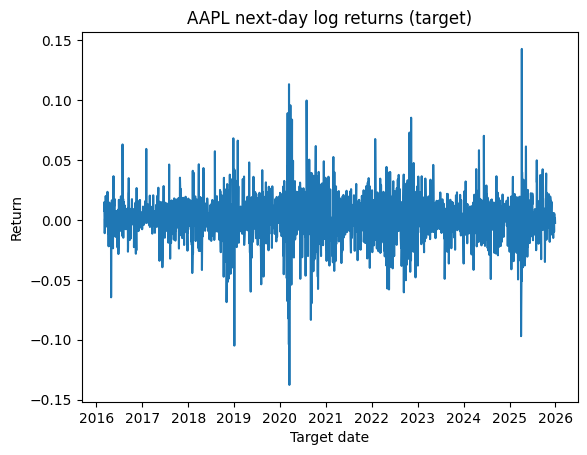

In [14]:
# Load processed data
panel = pd.read_parquet(PROC_DIR / "panel.parquet")

# 1) Check split coverage
print(panel.groupby(["Ticker", "split"]).size().unstack(fill_value=0))

# 2) Target must be later than feature date
bad_rows = (panel["target_date"] <= panel["Date"]).sum()
print("Rows where target_date <= Date (should be 0):", bad_rows)

# 3) Plot one ticker target series
one = panel[panel["Ticker"] == "AAPL"].sort_values("target_date")

plt.figure()
plt.plot(one["target_date"], one["target_ret"])
plt.title("AAPL next-day log returns (target)")
plt.xlabel("Target date")
plt.ylabel("Return")
plt.show()

In [22]:
import pandas as pd
from pathlib import Path

def find_existing_path(candidates):
    for p in candidates:
        p = Path(p)
        if p.exists():
            return p
    raise FileNotFoundError("Could not find file in candidates:\n" + "\n".join(map(str, candidates)))

# Locate the panel file (works whether you used stock_project/ or data/)
panel_path = find_existing_path([
    "stock_project/data/processed/panel.parquet",
    "data/processed/panel.parquet"
])

# Set output dirs near the panel file
project_root = panel_path.parents[2]  # .../data/processed/panel.parquet -> project_root = ...
tables_dir = project_root / "reports" / "tables"
tables_dir.mkdir(parents=True, exist_ok=True)

panel = pd.read_parquet(panel_path)

FEATURE_DICT = {
    # Identifiers
    "Date": "Feature date t (information up to end of day t).",
    "Ticker": "Asset identifier (stock symbol).",
    "split": "Train/val/test split label based on target_date.",

    # Targets and returns
    "ret": "Log return on date t: log(P_t) - log(P_{t-1}).",
    "target_ret": "Next-day log return to predict: log(P_{t+1}) - log(P_t).",
    "target_date": "Date corresponding to target_ret (t+1).",

    # Stock lags
    "ret_lag1": "Stock return at t-1.",
    "ret_lag2": "Stock return at t-2.",
    "ret_lag3": "Stock return at t-3.",
    "ret_lag5": "Stock return at t-5.",
    "ret_lag10": "Stock return at t-10.",

    # Rolling vol
    "ret_vol5": "Rolling std of returns over last 5 days ending at t.",
    "ret_vol10": "Rolling std of returns over last 10 days ending at t.",
    "ret_vol20": "Rolling std of returns over last 20 days ending at t.",

    # Market/VIX (lagged)
    "mkt_ret_lag1": "SPY market log return at t-1.",
    "vix_level_lag1": "VIX level (close) at t-1.",
    "vix_ret_lag1": "VIX log return at t-1.",

    # FRED levels (lagged)
    "DFF_lag1": "Effective Fed Funds Rate at t-1 (forward-filled to trading days).",
    "DGS10_lag1": "10-year Treasury yield at t-1 (forward-filled).",
    "SP500_lag1": "S&P500 index level at t-1 (from FRED, forward-filled).",

    # FRED transforms (lagged)
    "sp500_ret_lag1": "Log return of FRED SP500 level at t-1.",
    "DFF_diff_lag1": "Daily change in DFF at t-1.",
    "DGS10_diff_lag1": "Daily change in DGS10 at t-1.",
}

# Build a clean table in the same order as your panel columns
rows = []
for col in panel.columns:
    rows.append({
        "feature_name": col,
        "role": ("target" if col == "target_ret"
                 else "identifier" if col in ["Date","Ticker","split","target_date"]
                 else "feature"),
        "definition": FEATURE_DICT.get(col, "No definition found yet (add to FEATURE_DICT)."),
    })

feature_table = pd.DataFrame(rows)

# Show missing definitions (if any)
missing = feature_table[feature_table["definition"].str.startswith("No definition")]
print("Columns missing a definition:", list(missing["feature_name"]))

# Save for paper / appendix
out_path = tables_dir / "feature_dictionary.csv"
feature_table.to_csv(out_path, index=False)

print("Saved feature dictionary to:", out_path.resolve())
feature_table

Columns missing a definition: []
Saved feature dictionary to: /notebooks/stock_project/stock_project/reports/tables/feature_dictionary.csv


,feature_name,role,definition
0,Date,identifier,Feature date t (information up to end of day t).
1,Ticker,identifier,Asset identifier (stock symbol).
2,ret,feature,Log return on date t: log(P_t) - log(P_{t-1}).
3,target_ret,target,Next-day log return to predict: log(P_{t+1}) -...
4,target_date,identifier,Date corresponding to target_ret (t+1).
5,mkt_ret_lag1,feature,SPY market log return at t-1.
6,vix_level_lag1,feature,VIX level (close) at t-1.
7,vix_ret_lag1,feature,VIX log return at t-1.
8,DFF_lag1,feature,Effective Fed Funds Rate at t-1 (forward-fille...
9,DGS10_lag1,feature,10-year Treasury yield at t-1 (forward-filled).


### KEY EDA PLOTS

## Summary stats table per ticker

In [23]:
import numpy as np
import pandas as pd

panel = pd.read_parquet(panel_path).copy()

def stats(x):
    return pd.Series({
        "mean": x.mean(),
        "std": x.std(),
        "ann_vol": x.std() * np.sqrt(252),
        "skew": x.skew(),
        "kurtosis": x.kurtosis(),  # Fisher (normal ~ 0)
        "p01": x.quantile(0.01),
        "p05": x.quantile(0.05),
        "p95": x.quantile(0.95),
        "p99": x.quantile(0.99),
    })

summary = (
    panel.groupby("Ticker")["target_ret"]
    .apply(stats)
    .reset_index()
)

out = tables_dir / "return_summary_stats_by_ticker.csv"
summary.to_csv(out, index=False)
print("Saved:", out.resolve())
summary

Saved: /notebooks/stock_project/stock_project/reports/tables/return_summary_stats_by_ticker.csv


,Ticker,level_1,target_ret
0,AAPL,mean,0.001004
1,AAPL,std,0.018212
2,AAPL,ann_vol,0.289113
3,AAPL,skew,-0.081866
4,AAPL,kurtosis,6.876197
...,...,...,...
67,TSLA,kurtosis,4.250884
68,TSLA,p01,-0.099016
69,TSLA,p05,-0.054889
70,TSLA,p95,0.058806


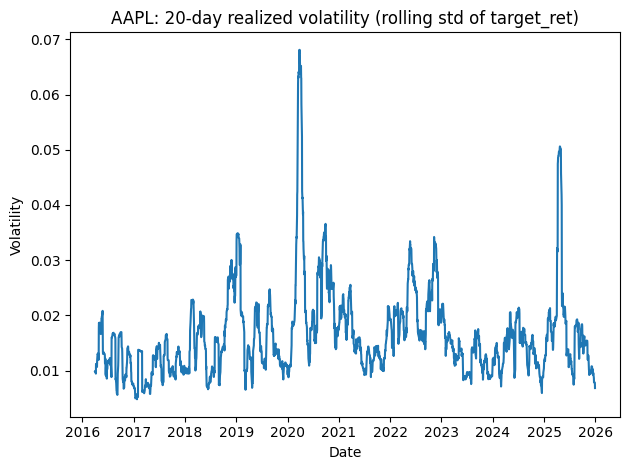

Saved: /notebooks/stock_project/stock_project/reports/figures/AAPL_rolling_vol20.png


In [24]:
import matplotlib.pyplot as plt

ticker = "AAPL"
df = panel[panel["Ticker"] == ticker].sort_values("target_date").copy()

# realized vol proxy (rolling std of next-day return)
df["realized_vol20"] = df["target_ret"].rolling(20).std()

plt.figure()
plt.plot(df["target_date"], df["realized_vol20"])
plt.title(f"{ticker}: 20-day realized volatility (rolling std of target_ret)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.tight_layout()

fig_path = (project_root / "reports" / "figures")
fig_path.mkdir(parents=True, exist_ok=True)
out = fig_path / f"{ticker}_rolling_vol20.png"
plt.savefig(out, dpi=200)
plt.show()

print("Saved:", out.resolve())

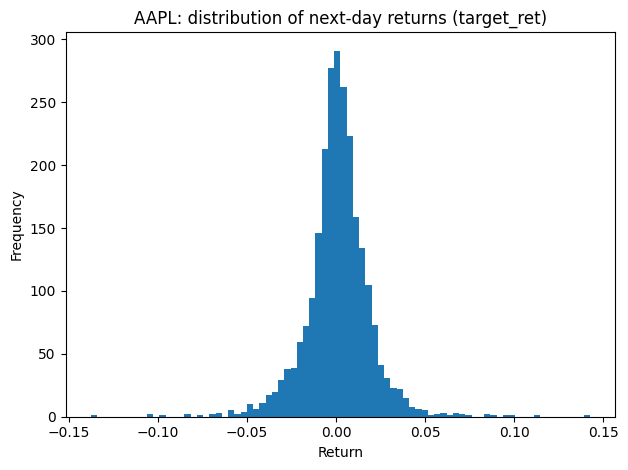

Saved: /notebooks/stock_project/stock_project/reports/figures/AAPL_return_hist.png


In [25]:
ticker = "AAPL"
df = panel[panel["Ticker"] == ticker].copy()

plt.figure()
plt.hist(df["target_ret"], bins=80)
plt.title(f"{ticker}: distribution of next-day returns (target_ret)")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.tight_layout()

out = fig_path / f"{ticker}_return_hist.png"
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out.resolve())

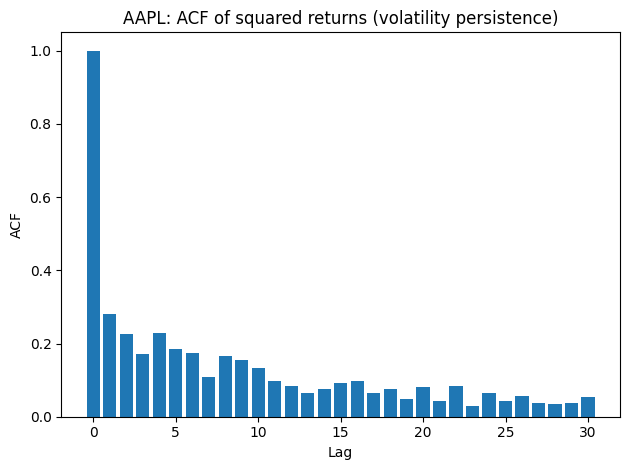

Saved: /notebooks/stock_project/stock_project/reports/figures/AAPL_acf_squared_returns.png


In [26]:
import numpy as np
import matplotlib.pyplot as plt

def simple_acf(x, nlags=30):
    x = np.asarray(x)
    x = x - x.mean()
    denom = np.dot(x, x)
    acf_vals = [1.0]
    for lag in range(1, nlags + 1):
        acf_vals.append(np.dot(x[lag:], x[:-lag]) / denom)
    return np.array(acf_vals)

ticker = "AAPL"
x = panel.loc[panel["Ticker"] == ticker, "target_ret"].dropna().to_numpy()
acf_sq = simple_acf(x**2, nlags=30)

plt.figure()
plt.bar(np.arange(len(acf_sq)), acf_sq)
plt.title(f"{ticker}: ACF of squared returns (volatility persistence)")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.tight_layout()

out = fig_path / f"{ticker}_acf_squared_returns.png"
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out.resolve())

### Why GARCH and what are we forecasting?

Daily returns are not i.i.d. in practice. A very common pattern is **volatility clustering**:

- calm periods tend to be followed by calm periods  
- volatile periods tend to be followed by volatile periods  

GARCH models do not mainly “predict the price direction.”  
They model **time-varying uncertainty**, i.e., the conditional variance of returns.

Let daily log return be:

$$
r_t = \log(P_t) - \log(P_{t-1})
$$

A standard volatility model decomposes returns as:

$$
r_t = \mu + \epsilon_t
$$

$$
\epsilon_t = \sigma_t z_t, \quad z_t \sim \text{i.i.d. } (0,1)
$$

So:

- $\sigma_t$ is the conditional volatility at time $t$
- the key task is to model how $\sigma_t$ evolves over time


#### GARCH(1,1)

$$
\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2
$$

**Intuition:**

- If yesterday’s shock $\epsilon_{t-1}$ was large, tomorrow’s variance increases  
- Variance is persistent via $\beta \sigma_{t-1}^2$

Typical constraints:

$$
\omega > 0, \quad \alpha \ge 0, \quad \beta \ge 0, \quad \alpha + \beta < 1
$$


#### GJR-GARCH(1,1) (leverage / asymmetry)

Negative returns often increase volatility more than positive returns of the same size.

$$
\sigma_t^2 =
\omega
+ \alpha \epsilon_{t-1}^2
+ \gamma \mathbf{1}(\epsilon_{t-1} < 0)\epsilon_{t-1}^2
+ \beta \sigma_{t-1}^2
$$


#### EGARCH(1,1)

Uses log-variance so positivity is automatic:

$$
\log(\sigma_t^2)
=
\omega
+ \alpha (|z_{t-1}| - E|z|)
+ \gamma z_{t-1}
+ \beta \log(\sigma_{t-1}^2)
$$


For each ticker:

1. Fit each volatility model **using only the training window** (no test leakage).  
2. Produce **1-step-ahead variance forecasts**:

$$
\widehat{\sigma^2_{t+1|t}}
$$

3. Merge these forecasts into the panel as features so we can build:
   - pure econometric volatility benchmarks
   - hybrids like GARCH–GRU/LSTM

We will evaluate volatility forecasts using a standard loss (QLIKE):

$$
L_t
=
\log(\hat{\sigma}^2_{t+1|t})
+
\frac{r_{t+1}^2}{\hat{\sigma}^2_{t+1|t}}
$$

Lower is better.

In [15]:
from pathlib import Path
import shutil

# One project root folder
PROJECT_DIR = Path("stock_project")

RAW_DIR  = PROJECT_DIR / "data" / "raw"
PROC_DIR = PROJECT_DIR / "data" / "processed"
FIG_DIR  = PROJECT_DIR / "reports" / "figures"
TAB_DIR  = PROJECT_DIR / "reports" / "tables"

for d in [RAW_DIR, PROC_DIR, FIG_DIR, TAB_DIR]:
    d.mkdir(parents=True, exist_ok=True)

OLD_RAW_DIR = Path("data/raw")
OLD_PROC_DIR = Path("data/processed")

to_copy = [
    (OLD_RAW_DIR / "prices_adj_close.csv", RAW_DIR / "prices_adj_close.csv"),
    (OLD_RAW_DIR / "fred_macro.csv",       RAW_DIR / "fred_macro.csv"),
    (OLD_PROC_DIR / "panel.parquet",       PROC_DIR / "panel.parquet"),
    (OLD_PROC_DIR / "audit_summary.csv",   PROC_DIR / "audit_summary.csv"),
]

for src, dst in to_copy:
    if src.exists() and not dst.exists():
        shutil.copy2(src, dst)
        print(f"Copied {src} -> {dst}")

print("Project root:", PROJECT_DIR.resolve())
print("RAW_DIR:", RAW_DIR)
print("PROC_DIR:", PROC_DIR)
print("TAB_DIR:", TAB_DIR)

Copied data/raw/prices_adj_close.csv -> stock_project/data/raw/prices_adj_close.csv
Copied data/raw/fred_macro.csv -> stock_project/data/raw/fred_macro.csv
Copied data/processed/panel.parquet -> stock_project/data/processed/panel.parquet
Copied data/processed/audit_summary.csv -> stock_project/data/processed/audit_summary.csv
Project root: /notebooks/stock_project/stock_project
RAW_DIR: stock_project/data/raw
PROC_DIR: stock_project/data/processed
TAB_DIR: stock_project/reports/tables


In [16]:
import sys, subprocess

try:
    from arch import arch_model
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "arch"])
    from arch import arch_model

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

print("arch_model imported successfully")

arch_model imported successfully


In [21]:
import json

tickers = panel["Ticker"].unique()

SCALE = 100.0  # scale returns to percent for numerical stability

def last_obs_exclusive_loc(index: pd.DatetimeIndex, last_date_inclusive: pd.Timestamp) -> int:
    """
    arch.fit(last_obs=...) uses python slicing rules (exclusive).
    We convert an inclusive date cutoff into an exclusive integer location.
    """
    in_sample = index[index <= last_date_inclusive]
    if len(in_sample) == 0:
        raise ValueError("No observations <= last_date_inclusive. Check your cutoff date.")
    last_date = in_sample.max()
    return index.get_loc(last_date) + 1  # exclusive location

MODEL_SPECS = {
    # Standard symmetric GARCH(1,1)
    "garch11_t":  dict(mean="Zero", vol="GARCH",  p=1, o=0, q=1, dist="t"),
    # GJR-GARCH(1,1) (asymmetry / leverage)
    "gjr11_t":    dict(mean="Zero", vol="GARCH",  p=1, o=1, q=1, dist="t"),
    # EGARCH(1,1) (log variance dynamics)
    "egarch11_t": dict(mean="Zero", vol="EGARCH", p=1, o=1, q=1, dist="t"),
}

def fit_and_forecast_var1(y_pct: pd.Series, spec: dict, last_obs_excl: int) -> tuple:
    """
    Fit model on y_pct[:last_obs_excl], then produce 1-step-ahead variance forecasts var_{t+1|t}
    aligned to y_pct.index (origin alignment).
    """
    am = arch_model(y_pct, rescale=False, **spec)
    res = am.fit(disp="off", update_freq=0, last_obs=last_obs_excl)
    fc = res.forecast(horizon=1, start=0, reindex=True, align="origin")
    var1 = fc.variance["h.1"]  # time-t forecast for time t+1
    return res, var1

garch_feature_frames = []
fit_rows = []

for ticker in tickers:
    # One return series per ticker (log returns)
    s = (
        panel.loc[panel["Ticker"] == ticker, ["Date", "ret"]]
        .drop_duplicates(subset=["Date"])
        .set_index("Date")["ret"]
        .sort_index()
    )

    # Scale to percent
    y_pct = SCALE * s

    # Fit only up to end of TRAIN (no leakage)
    last_obs_excl = last_obs_exclusive_loc(y_pct.index,TRAIN_END )

    for model_name, spec in MODEL_SPECS.items():
        try:
            res, var1_pct2 = fit_and_forecast_var1(y_pct, spec, last_obs_excl)

            # Convert variance back to return-units (not percent^2)
            var1 = (var1_pct2 / (SCALE**2)).rename(f"{model_name}_var1")
            sigma1 = np.sqrt(var1).rename(f"{model_name}_sigma1")

            df_feat = pd.concat([var1, sigma1], axis=1).reset_index().rename(columns={"index": "Date"})
            df_feat["Ticker"] = ticker
            garch_feature_frames.append(df_feat)

            fit_rows.append({
                "Ticker": ticker,
                "model": model_name,
                "nobs_total": len(y_pct),
                "nobs_fit": int(last_obs_excl),
                "loglik": float(res.loglikelihood),
                "aic": float(res.aic),
                "bic": float(res.bic),
                "params_json": json.dumps(res.params.to_dict()),
            })

            print(f"[OK] {ticker:5s} {model_name:10s} | fit_n={last_obs_excl} | AIC={res.aic:.2f}")
        except Exception as e:
            print(f"[FAIL] {ticker:5s} {model_name:10s} -> {repr(e)}")

garch_features = pd.concat(garch_feature_frames, ignore_index=True)
fit_summary = pd.DataFrame(fit_rows)

garch_path = PROC_DIR / "garch_features_trainfit.parquet"
fit_path = TAB_DIR / "garch_fit_summary_trainfit.csv"

garch_features.to_parquet(garch_path, index=False)
fit_summary.to_csv(fit_path, index=False)

print("Saved:", garch_path)
print("Saved:", fit_path)
fit_summary.head()

[OK] AAPL  garch11_t  | fit_n=966 | AIC=3282.36
[OK] AAPL  gjr11_t    | fit_n=966 | AIC=3253.30
[OK] AAPL  egarch11_t | fit_n=966 | AIC=3246.76
[OK] AMZN  garch11_t  | fit_n=966 | AIC=3396.33
[OK] AMZN  gjr11_t    | fit_n=966 | AIC=3379.17
[OK] AMZN  egarch11_t | fit_n=966 | AIC=3380.40
[OK] GOOGL garch11_t  | fit_n=966 | AIC=3118.79
[OK] GOOGL gjr11_t    | fit_n=966 | AIC=3111.52
[OK] GOOGL egarch11_t | fit_n=966 | AIC=3109.29
[OK] META  garch11_t  | fit_n=966 | AIC=3459.70
[OK] META  gjr11_t    | fit_n=966 | AIC=3444.97
[OK] META  egarch11_t | fit_n=966 | AIC=3428.65
[OK] MSFT  garch11_t  | fit_n=966 | AIC=3064.16
[OK] MSFT  gjr11_t    | fit_n=966 | AIC=3037.97
[OK] MSFT  egarch11_t | fit_n=966 | AIC=3031.49
[OK] NVDA  garch11_t  | fit_n=966 | AIC=4380.28
[OK] NVDA  gjr11_t    | fit_n=966 | AIC=4363.42
[OK] NVDA  egarch11_t | fit_n=966 | AIC=4356.84
[OK] ORCL  garch11_t  | fit_n=966 | AIC=2875.70
[OK] ORCL  gjr11_t    | fit_n=966 | AIC=2874.72
[OK] ORCL  egarch11_t | fit_n=966 | AIC=

,Ticker,model,nobs_total,nobs_fit,loglik,aic,bic,params_json
0,AAPL,garch11_t,2472,966,-1637.181964,3282.363929,3301.856584,"{""omega"": 0.19974829533880578, ""alpha[1]"": 0.1..."
1,AAPL,gjr11_t,2472,966,-1621.651027,3253.302055,3277.667874,"{""omega"": 0.14403073566879998, ""alpha[1]"": 0.0..."
2,AAPL,egarch11_t,2472,966,-1618.379216,3246.758432,3271.124251,"{""omega"": 0.0758149937463695, ""alpha[1]"": 0.18..."
3,AMZN,garch11_t,2472,966,-1694.162543,3396.325087,3415.817742,"{""omega"": 0.1731464469249476, ""alpha[1]"": 0.17..."
4,AMZN,gjr11_t,2472,966,-1684.584529,3379.169057,3403.534877,"{""omega"": 0.19342467750414297, ""alpha[1]"": 0.0..."
